# Step 1. Import packets and Load Minst Data from file

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
#For remote: Usually colab.research.google.com
#mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)
#For local:
mnist = mnist_data.read_data_sets(r"D:\MachineLearning\minst", one_hot=True, reshape=False, validation_size=0)

Tensorflow version 1.4.0
Extracting D:\MachineLearning\minst\train-images-idx3-ubyte.gz
Extracting D:\MachineLearning\minst\train-labels-idx1-ubyte.gz
Extracting D:\MachineLearning\minst\t10k-images-idx3-ubyte.gz
Extracting D:\MachineLearning\minst\t10k-labels-idx1-ubyte.gz


# Step 2. Set up learning model, train the network and save checkpoint

In [3]:
# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1],name = 'Input')
# correct answers will go here
Y_LABEL = tf.placeholder(tf.float32, [None, 10],name = 'Label')
# variable learning rate
lr = tf.placeholder(tf.float32)
# test flag for batch norm
iftraining = tf.placeholder(tf.bool,name = 'Mode')
# dropout probability


def batch_normal(X,iftraining):
    return  tf.layers.batch_normalization(X, training=iftraining)


def hidden_cnn_layer(X, sizeOutput,kernal, stride, activation = 'sigmoid',bn_enable = False,iftraining = True):
    W = tf.Variable(tf.truncated_normal([int(kernal), int(kernal), int(X.shape[-1]), int(sizeOutput)], stddev=0.1))
    #B = tf.Variable(tf.zeros(sizeOutput))   #Not necessary in bn as offset exists
    #Y = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME') + B
    Y = tf.nn.conv2d(X, W, strides=[1, int(stride), int(stride), 1], padding='SAME')
    if bn_enable:    Y_bn = batch_normal(Y, iftraining)
    else:            Y_bn = Y
    if activation == 'sigmoid':    A = tf.nn.sigmoid(Y_bn)
    elif activation == 'relu':     A = tf.nn.relu(Y_bn)
    else:                          A = Y_bn
      
    return A
                             

def hidden_fc_layer(X,sizeOutput,activation = '',bn_enable = False,iftraining = True):
    W = tf.Variable(tf.truncated_normal([int(X.shape[-1]), sizeOutput], stddev=0.1))
    if bn_enable == False:
        B = tf.Variable(tf.zeros(sizeOutput))   #Not necessary in bn as offset exists
        Y = tf.matmul(X,W) + B
    else:         
        Y_linear = tf.matmul(X,W)
        Y = batch_normal(Y_linear, iftraining)

    if activation == 'sigmoid':     A = tf.nn.sigmoid(Y)
    elif activation == 'relu':      A = tf.nn.relu(Y)
    else:                           A = Y

    return A

A1 = hidden_cnn_layer(X, sizeOutput=24, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A2 = hidden_cnn_layer(A1,sizeOutput=48, kernal=5, stride=2, activation ='relu', bn_enable=True, iftraining = iftraining)
A3 = hidden_cnn_layer(A2,sizeOutput=64, kernal=5, stride=2, activation ='relu', bn_enable=True, iftraining = iftraining)

size = 1
for i in range(1,len(A3.shape)):     size*= int(A3.shape[i])
print(size)
A3_reshape = tf.reshape(A3,[-1,size])
print(A3_reshape.shape)
print(A3.shape)
A4 = hidden_fc_layer(A3_reshape,sizeOutput = 200,activation ='relu', bn_enable=True, iftraining = iftraining)
Y_linear = hidden_fc_layer(A4,sizeOutput = 10)
Y_predict       = tf.nn.softmax(Y_linear,name = 'Y_predict')


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=Y_LABEL, logits=Y_linear))*100
optimizer = tf.train.AdamOptimizer(lr)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(cross_entropy)

3136
(?, 3136)
(?, 7, 7, 64)


In [4]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

max_learning_rate = 0.015
min_learning_rate = 0.001
decay_speed = 1000.0

import time
time_start=time.time()/1000.    #1970.1.1开始到现在的秒数

saver = tf.train.Saver()   
for _ in range(1000+1):
  batch_xs, batch_ys = mnist.train.next_batch(1000)
  learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-_/decay_speed)
  sess.run(train_step, feed_dict={X: batch_xs, Y_LABEL: batch_ys, lr: learning_rate, iftraining: True})

  if _%100 == 0:  
    correct_prediction = tf.equal(tf.argmax(Y_linear, 1), tf.argmax(Y_LABEL, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(_, sess.run(accuracy, feed_dict={X: mnist.test.images, Y_LABEL: mnist.test.labels, iftraining: True}))
    saver.save(sess, "./Model_Minst/CNN_bn.ckpt",global_step= _ )

time_end=time.time()/1000.
print('totally cost (s)',time_end-time_start)

0 0.7351
100 0.9897
200 0.991
300 0.9912


KeyboardInterrupt: 

# Step 3. Freeze learning model. Use checkpoint file to generate pb file

In [5]:
import tensorflow as tf
with tf.Session() as sess:

    #初始化变量
    sess.run(tf.global_variables_initializer())

    #获取最新的checkpoint，其实就是解析了checkpoint文件
    latest_ckpt = tf.train.latest_checkpoint("./Model_Minst")

    #加载图
    restore_saver = tf.train.import_meta_graph('./Model_Minst/CNN_bn.ckpt-300.meta')

    #恢复图，即将weights等参数加入图对应位置中
    restore_saver.restore(sess, latest_ckpt)

    #将图中的变量转为常量
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, sess.graph_def , ["Y_predict"])
    #将新的图保存到"/pretrained/graph.pb"文件中
    tf.train.write_graph(output_graph_def, 'pretrained', "graph.pb", as_text=False)

INFO:tensorflow:Restoring parameters from ./Model_Minst\CNN_bn.ckpt-300
INFO:tensorflow:Froze 22 variables.
Converted 22 variables to const ops.


# Step 4. Prediction: Test batch size increase from 1

In [11]:
import numpy as np
import tensorflow as tf


def recognize(img_input, pb_file_path):
    with tf.Graph().as_default():
        output_graph_def = tf.GraphDef()

        with open(pb_file_path, "rb") as f:
            output_graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(output_graph_def, name="")

        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)

            input_x = sess.graph.get_tensor_by_name("Input:0")
            # print input_x
            mode = sess.graph.get_tensor_by_name('Mode:0')
            out_softmax = sess.graph.get_tensor_by_name("Y_predict:0")
            
            img_try = img_input
            test_input = np.float32(img_try)
            img_out_softmax = sess.run(out_softmax, feed_dict={input_x:test_input,mode: False})
            prediction_labels = np.argmax(img_out_softmax, axis=1)
            return prediction_labels


start = 0
for i in range(1,26):
    r = recognize(mnist.test.images[start:start+i], "./pretrained/graph.pb")
    print(r)
    #print(listmapping(r,TV_LOGO_s))

[7]
[7 2]
[7 2 1]
[7 2 1 0]
[7 2 1 0 4]
[7 2 1 0 4 1]
[7 2 1 0 4 1 4]
[7 2 1 0 4 1 4 9]
[7 2 1 0 4 1 4 9 5]
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9 0]
[7 2 1 0 4 1 4 9 5 9 0 6]
[7 2 1 0 4 1 4 9 5 9 0 6 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]


# Step 5. Plot the test results

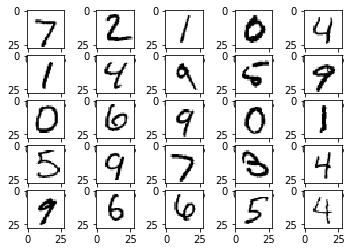

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]


In [17]:
import matplotlib.pyplot as plt
for i in range(25):
    plt.subplot(5,5,i+1)
    image_data = mnist.test.images[start+i].reshape([28,28])
    image = plt.imshow(image_data,cmap=plt.get_cmap('gray_r'))
plt.show()
result_s = np.argmax(mnist.test.labels[start:start+25],1)
print(result_s)